In [1]:
#  in this notebook varya is trying to implement catboost library for the catchment probability prediction 

In [5]:
# !pip install catboost
# !pip install ipywidgets

# catboost tutorial: 
# https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

In [6]:
import catboost
print(catboost.__version__)
!python --version

1.0.6
Python 3.7.11


In [7]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

# train and test:
from sklearn.model_selection import train_test_split

!jupyter nbextension enable --py widgetsnbextension


# some opinions:
# https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [16]:
# read the data: 

path = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/data_current/'
# df = pd.read_csv(path + 'dfclim_3aug_rainydays.csv', sep = ',', index_col = 0)
df = pd.read_csv(path + '09082022dfclim_permafrost.csv', sep = ',', index_col = 0)

df = df[df.target.isin([1,0])]
df = df.drop(['DN', 'Name', 'mean_daylymonsoon_tp_x'], axis = 1)


In [14]:
# df.columns



Index(['target', 'x_centroid', 'y_centroid', 'area_m', 'perimeter',
       'glaciersum', 'mean_elevation', 'median_elevation', 'std_elevation',
       'min_elevation', 'max_elevation', 'range_elevation',
       'variance_elevation', 'region', 'region_name', 'mean_slope',
       'median_slope', 'std_slope', 'min_slope', 'max_slope', 'range_slope',
       'variance_slope', 'glarea_percent', 'glacier', 'x_wgs', 'y_wgs', 'M',
       'Rc', 'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T',
       'mean_monsoon_T', 'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_x', 'mean_daylymonsoon_tp_y',
       'mean_monsoon_sum_tp', 'monsoon_tp_frac', 'n_rainy_days',
       'rainy_days_frac', 'permafrost1', 'permafrost1_frac', 'permafrost2',
       'permafrost2_frac', 'permafrost3', 'permafrost3_frac', 'permafrost4',
       'permafrost4_frac', 'cont_permafrost', 'cont_permafrost_frac50',
       'all_pe

In [15]:
# df.columns

df['region_name'].value_counts()

# print('cat features': list(range(0, X.shape[1])))

tadjikistan       233
karakorum         166
chitral            89
eastTSH            84
interior tibet     84
langtang           32
nyanq              24
Name: region_name, dtype: int64

In [18]:
# define X and y 
y = df.target
X = df.drop(['target', 'region_name'], axis=1)


# # what values are categorical: 
# # region, glacier, avgtemp_belowzero, cont_permafrost, any_permafrost, cont_permafrost_frac50
X['glacier'] = X['glacier'].astype('category') # n 21
X['region'] = X['region'].astype('category') # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype('category') # n 34
X['cont_permafrost'] = X['cont_permafrost'].astype('category') # n 51
X['any_permafrost'] = X['any_permafrost'].astype('category') # n 52
X['cont_permafrost_frac50'] = X['cont_permafrost_frac50'].astype('category') # n 54



In [21]:
# X.columns

# 13, 22, 35, 52, 53, 55 - cat features 

In [32]:
# cat features: 
# X.columns
cat_features = list([12, 21, 34, 50, 51, 53])
# type(cat_features)


In [33]:
print('Labels: {}'.format(set(y)))
print('FF (0) count = {}, DF (1) count = {}'.format(len(y) - sum(y), sum(y)))


Labels: {0, 1}
FF (0) count = 173, DF (1) count = 539


## Pool data class (?) 

#### catboost needs data to be stored as a "pool" thing for some functions 

# catboost classifier 

### train test 

In [34]:
from sklearn.model_selection import train_test_split

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=test_size, random_state=seed)

### classifier 

In [35]:
from catboost import CatBoostClassifier
# logloss - default(?)
# CrossEntropy - for probabilities 

model = CatBoostClassifier(
    iterations=95,
    learning_rate=0.1,
    loss_function='CrossEntropy'
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 95, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}


In [95]:
### standart out of the training

# model = CatBoostClassifier(
#     iterations=100,
# #     verbose=5,
# )
# model.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_validation, y_validation),
# )

In [111]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    use_best_model= True,
    custom_loss=['AUC', 'Accuracy'],
)


model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

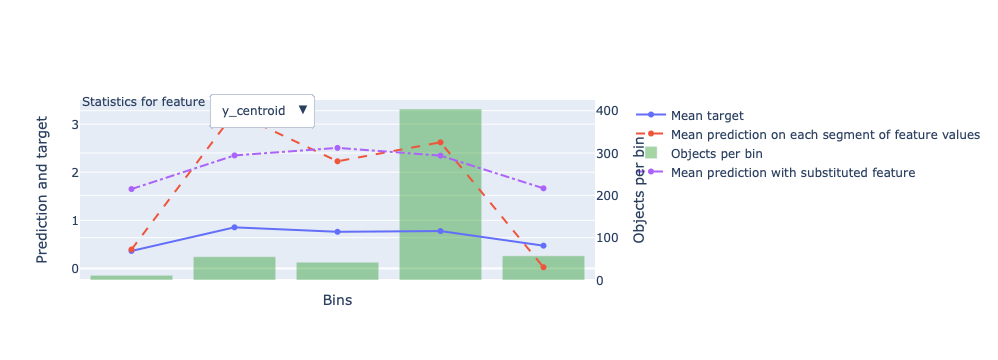

In [132]:
res = model.calc_feature_statistics(X_train,
                                    y_train,
                                    feature=[1, 2, 3, 4],
                                    plot=True)


## model predict probabilities (the entire dataset)

In [120]:
probs = model.predict_proba(X)


### feature importsnce

In [172]:
feature_import = model.get_feature_importance(prettified=True)
feature_import

,Feature Id,Importances
0,area_m,15.159030
1,range_elevation,12.044861
2,x_centroid,11.464264
3,mean_slope,8.814833
4,median_slope,7.448238
5,min_elevation,5.693697
6,y_centroid,5.384608
7,Rc,4.414305
8,max_slope,4.168981
9,rainy_days_frac,3.971328


Text(0.5, 1.0, 'Feature Importance')

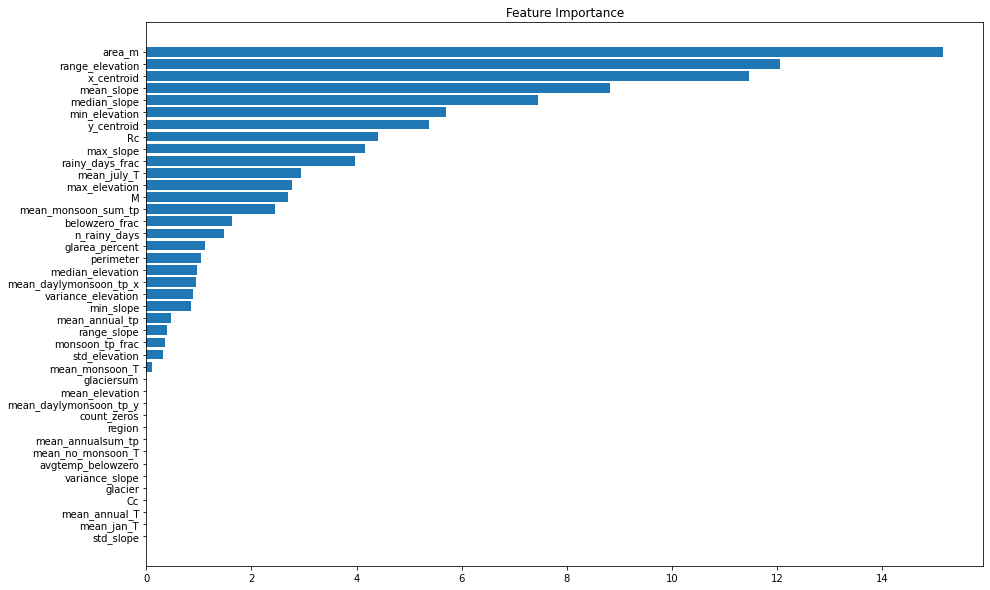

In [176]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_validation.columns)[sorted_idx])
plt.title('Feature Importance')

### shap stuff

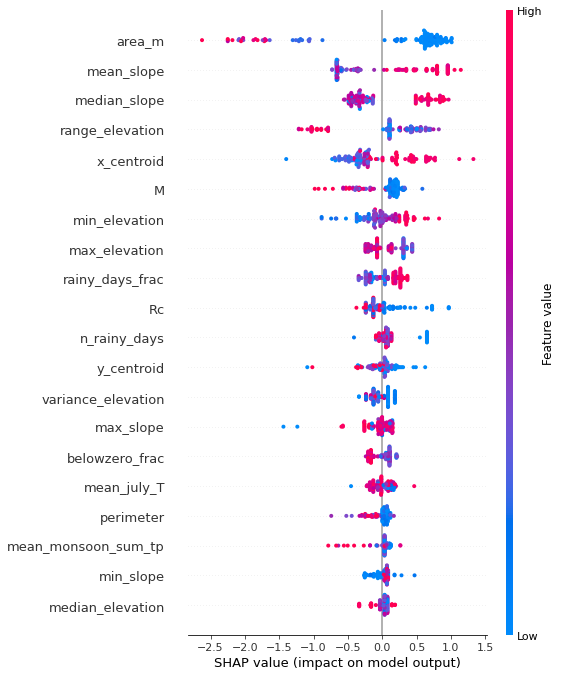

In [194]:
import shap 


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_validation)#, cat_features=cat_features)

shap.summary_plot(shap_values, X_validation)

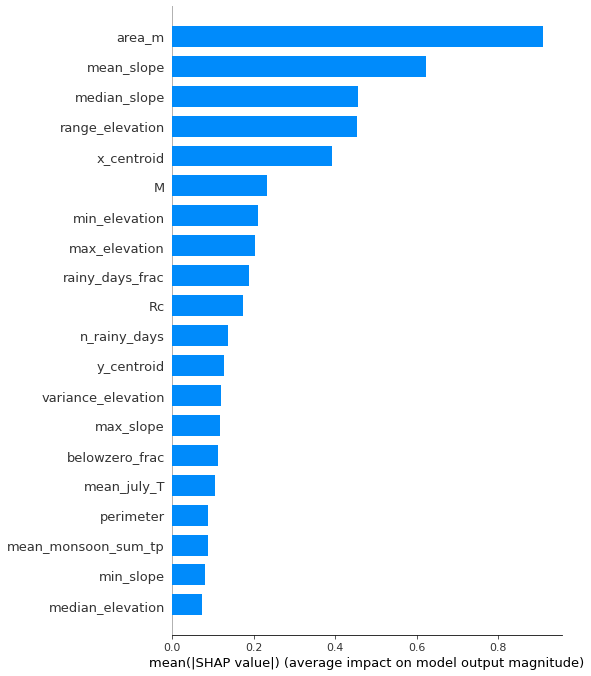

In [178]:
shap.summary_plot(shap_values, X_validation, plot_type="bar")

# shap.plots.bar(shap_values, max_display=X_validation.shape[0])


In [192]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
# shap.force_plot(explainer.expected_value, shap_values, X)


### apply the model 


In [179]:
y_result = model.predict(X)

y_result_probs = model.predict_proba(X)
y_result_probs = y_result_probs[:,1]

df['y_result'] = y_result
df['y_result_probs'] = y_result_probs


(array([ 21.,  24.,  15.,  16.,  11.,  10.,   5.,   8.,   8.,   3.,   2.,
          2.,   6.,   6.,   2.,   2.,   2.,   3.,   0.,   1.,   0.,   4.,
          2.,   1.,   1.,   3.,   7.,   1.,   2.,   4.,   2.,   3.,   5.,
          5.,   6.,   7.,   1.,   3.,   5.,   2.,   8.,   5.,  20.,  20.,
         18.,  23.,  26.,  51.,  64., 266.]),
 array([0.014 , 0.0337, 0.0534, 0.0731, 0.0928, 0.1126, 0.1323, 0.152 ,
        0.1717, 0.1914, 0.2111, 0.2309, 0.2506, 0.2703, 0.29  , 0.3097,
        0.3294, 0.3492, 0.3689, 0.3886, 0.4083, 0.428 , 0.4477, 0.4675,
        0.4872, 0.5069, 0.5266, 0.5463, 0.566 , 0.5858, 0.6055, 0.6252,
        0.6449, 0.6646, 0.6843, 0.7041, 0.7238, 0.7435, 0.7632, 0.7829,
        0.8026, 0.8224, 0.8421, 0.8618, 0.8815, 0.9012, 0.9209, 0.9407,
        0.9604, 0.9801, 0.9998]),
 <BarContainer object of 50 artists>)

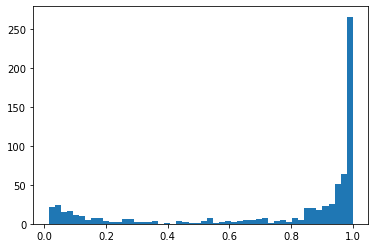

In [183]:
plt.hist(y_result_probs, bins = 50)

### partial depend stuff


Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


(0.0, 1.0)

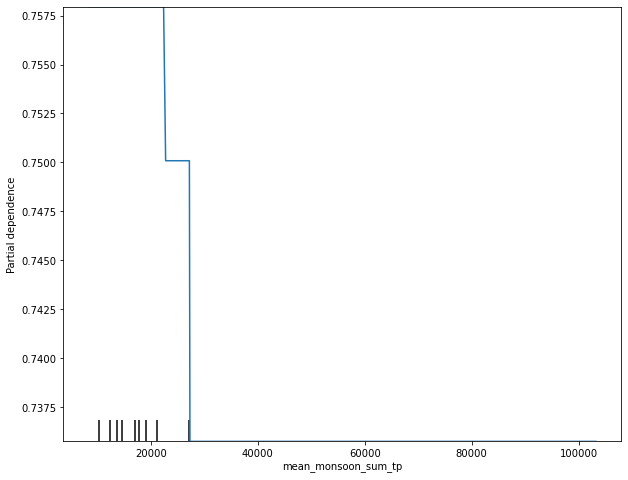

In [202]:
# see this as background: 
# https://christophm.github.io/interpretable-ml-book/pdp.html

from sklearn.inspection import partial_dependence, plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylim(0, 1)

my_plots = plot_partial_dependence(model,       
                                   features=['mean_monsoon_sum_tp'],       # column numbers of plots we want to show
                                   X=X,                        # raw predictors data.
                                   grid_resolution=300,
                                   response_method='predict_proba', 
                                   ax=ax)  # number of values to plot on x axis
ax.set_ylim(0, 1)

# plt.savefig('figs/pdp_mean_elev.pdf')

In [201]:
X.columns

Index(['x_centroid', 'y_centroid', 'area_m', 'perimeter', 'glaciersum',
       'mean_elevation', 'median_elevation', 'std_elevation', 'min_elevation',
       'max_elevation', 'range_elevation', 'variance_elevation', 'region',
       'mean_slope', 'median_slope', 'std_slope', 'min_slope', 'max_slope',
       'range_slope', 'variance_slope', 'glarea_percent', 'glacier', 'M', 'Rc',
       'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T', 'mean_monsoon_T',
       'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_x', 'mean_daylymonsoon_tp_y',
       'mean_monsoon_sum_tp', 'monsoon_tp_frac', 'n_rainy_days',
       'rainy_days_frac'],
      dtype='object')